# Librerías

In [1]:
import json
from PIL import Image
import torch
import os
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# FastRCNN (bb variables)

In [ ]:
import json
import os
import random
import torch
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms

# Ruta de las imágenes y del archivo JSON
image_dir = "base/"
json_file = "boxes_a_mano.json"

# Cargar JSON
with open(json_file) as f:
    data = json.load(f)

# Filtrar solo las imágenes con anotaciones
annotated_data = [item for item in data if item['annotations']]

# Dividir en conjuntos de entrenamiento (80%) y validación (20%)
random.shuffle(annotated_data)
split_idx = int(0.8 * len(annotated_data))
train_data = annotated_data[:split_idx]
val_data = annotated_data[split_idx:]

def get_boxes_and_labels(annotation):
    boxes = []
    labels = []
    for obj in annotation['annotations'][0]['result']:
        width, height = obj['original_width'], obj['original_height']
        x = obj['value']['x'] * width / 100
        y = obj['value']['y'] * height / 100
        box_width = obj['value']['width'] * width / 100
        box_height = obj['value']['height'] * height / 100
        boxes.append([x, y, x + box_width, y + box_height])
        # Asigna un número entero a cada categoría de etiqueta, por ejemplo:
        label = obj['value']['rectanglelabels'][0]
        labels.append(1 if label == 'LSIL' else 0)  # Ejemplo simple
    return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Creación del Dataset personalizado
class CellDataset(torch.utils.data.Dataset):
    def __init__(self, data, image_dir):
        self.data = data
        self.image_dir = image_dir

    def __getitem__(self, idx):
        item = self.data[idx]
        # Remover el prefijo antes del guion en el nombre del archivo
        image_name = item['file_upload'].split('-', 1)[-1]
        image_path = os.path.join(self.image_dir, image_name)
        
        # Verificar si el archivo existe
        if not os.path.exists(image_path):
            print(f"Advertencia: No se encontró la imagen {image_path}. Saltando...")
            return None

        image = Image.open(image_path).convert("RGB")
        boxes, labels = get_boxes_and_labels(item)
        target = {"boxes": boxes, "labels": labels}
        return transforms.ToTensor()(image), target

    def __len__(self):
        return len(self.data)

# Crear datasets de entrenamiento y validación
train_dataset = CellDataset(train_data, image_dir)
val_dataset = CellDataset(val_data, image_dir)

# Configurar DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [11]:
import wandb
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
import torch

# Iniciar un nuevo experimento en W&B
wandb.init(project="detecion-celulas", entity='tp3-td6', name="FastRCNN")

In [12]:
# Configuración inicial del modelo y otros parámetros
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 1 clase (objeto) + 1 (fondo)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
best_val_loss = float('inf')

# Registrar hiperparámetros en W&B
wandb.config.update({
    "learning_rate": 0.005,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "num_epochs": 10,
    "num_classes": num_classes
})

# Función corregida para calcular precisión basada en el promedio de predicciones correctas por imagen
def calculate_accuracy(pred_boxes, true_boxes, threshold=0.):
    ious = torchvision.ops.box_iou(pred_boxes, true_boxes)
    correct_preds = (ious >= threshold).any(dim=0).sum().item()
    return correct_preds / max(true_boxes.size(0), 1)

# Entrenamiento y Evaluación
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total_train_accuracy = 0
    num_train_samples = 0
    
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        train_loss += losses.item()

        model.eval()
        with torch.no_grad():
            outputs = model(images)
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].detach().cpu()
                true_boxes = targets[i]['boxes'].detach().cpu()
                total_train_accuracy += calculate_accuracy(pred_boxes, true_boxes)
                num_train_samples += 1
        model.train()
    
    train_loss /= len(train_loader)
    train_accuracy = total_train_accuracy / num_train_samples

    # Reportar las métricas de entrenamiento a W&B
    wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy})

    # Validación
    val_loss = 0
    total_val_accuracy = 0
    num_val_samples = 0
    model.train()  # Temporalmente en modo entrenamiento para calcular la pérdida
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Cálculo de pérdida en validación
            loss_dict = model(images, targets)
            val_losses = sum(loss for loss in loss_dict.values())
            val_loss += val_losses.item()

            model.eval()  # Modo evaluación para las predicciones de precisión
            outputs = model(images)
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].detach().cpu()
                true_boxes = targets[i]['boxes'].detach().cpu()
                total_val_accuracy += calculate_accuracy(pred_boxes, true_boxes)
                num_val_samples += 1
            model.train()  # Volver a modo entrenamiento para el siguiente batch

    val_loss /= len(val_loader)
    val_accuracy = total_val_accuracy / num_val_samples

    # Reportar las métricas de validación a W&B
    wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})

    # Guardar el mejor modelo y reportar a W&B
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        wandb.log({"best_val_loss": best_val_loss})
        print(f'Epoch {epoch+1}: val_loss improved to {val_loss:.5f}, saving model to best_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

# Finalizar el experimento de W&B
wandb.finish()

In [ ]:
# Selecciona una imagen y sus etiquetas desde el conjunto de validación
sample_idx = 3  # Cambia este valor para seleccionar otra imagen
sample = val_data[sample_idx]  # Cambiado a val_data para usar el conjunto de validación
image_path = os.path.join(image_dir, sample['file_upload'].split('-', 1)[-1])
true_boxes, _ = get_boxes_and_labels(sample)

# Realizar detección con el modelo entrenado
model.eval()
image_tensor = transforms.ToTensor()(Image.open(image_path)).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(image_tensor)[0]

# Extraer las bounding boxes y las puntuaciones de las predicciones
pred_boxes = output['boxes'].detach().cpu().numpy()
pred_scores = output['scores'].detach().cpu().numpy()
pred_boxes_with_scores = [(box, score) for box, score in zip(pred_boxes, pred_scores)]

# Visualizar la imagen con las bounding boxes reales y predichas
plot_boxes(image_path, true_boxes, pred_boxes_with_scores)

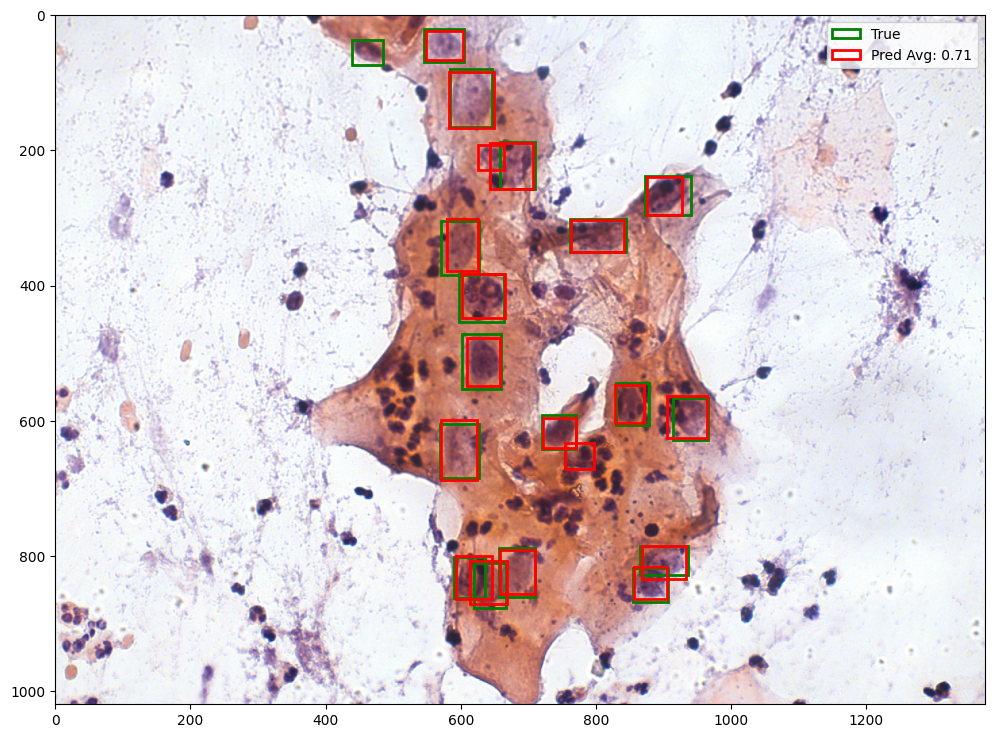

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def plot_boxes(image_path, true_boxes, pred_boxes_with_scores, pred_threshold=0.2):
    # Cargar la imagen
    image = Image.open(image_path).convert("RGB")
    
    # Crear una figura y un eje
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)
    
    # Dibujar las bounding boxes reales en verde
    for box in true_boxes:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='green', facecolor='none', label="True")
        ax.add_patch(rect)
    
    # Filtrar las bounding boxes predichas según el umbral
    filtered_boxes_with_scores = [(box, score) for box, score in pred_boxes_with_scores if score >= pred_threshold]
    
    if filtered_boxes_with_scores:
        # Calcular el promedio de los scores
        avg_score = np.mean([score for _, score in filtered_boxes_with_scores])
        
        # Dibujar las bounding boxes predichas con el score promedio como etiqueta
        for box, _ in filtered_boxes_with_scores:
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none', label=f"Pred Avg: {avg_score:.2f}")
            ax.add_patch(rect)
    
    # Mostrar la leyenda y la imagen
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    plt.show()

# Seleccionar una imagen del conjunto de validación y extraer las bounding boxes reales
sample_idx = 8  # Cambia este valor para seleccionar otra imagen
sample = val_data[sample_idx]
image_path = os.path.join(image_dir, sample['file_upload'].split('-', 1)[-1])
true_boxes, _ = get_boxes_and_labels(sample)

# Realizar detección con el modelo entrenado
model.eval()
image_tensor = transforms.ToTensor()(Image.open(image_path)).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(image_tensor)[0]

# Extraer las bounding boxes y los scores de las predicciones
pred_boxes = output['boxes'].detach().cpu().numpy()
pred_scores = output['scores'].detach().cpu().numpy()
pred_boxes_with_scores = [(box, score) for box, score in zip(pred_boxes, pred_scores)]

# Visualizar la imagen con las bounding boxes reales y predichas
plot_boxes(image_path, true_boxes, pred_boxes_with_scores)

# FasterRCNN Transfer Learning COCO (bb variables)

In [ ]:
import json
import os
import random
import torch
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms

# Ruta de las imágenes y del archivo JSON
image_dir = "base/"
json_file = "boxes_a_mano.json"

# Cargar JSON
with open(json_file) as f:
    data = json.load(f)

# Filtrar solo las imágenes con anotaciones
annotated_data = [item for item in data if item['annotations']]

# Dividir en conjuntos de entrenamiento (80%) y validación (20%)
random.shuffle(annotated_data)
split_idx = int(0.8 * len(annotated_data))
train_data = annotated_data[:split_idx]
val_data = annotated_data[split_idx:]

def get_boxes_and_labels(annotation):
    boxes = []
    labels = []
    for obj in annotation['annotations'][0]['result']:
        width, height = obj['original_width'], obj['original_height']
        x = obj['value']['x'] * width / 100
        y = obj['value']['y'] * height / 100
        box_width = obj['value']['width'] * width / 100
        box_height = obj['value']['height'] * height / 100
        boxes.append([x, y, x + box_width, y + box_height])
        # Asigna un número entero a cada categoría de etiqueta, por ejemplo:
        label = obj['value']['rectanglelabels'][0]
        labels.append(1 if label == 'LSIL' else 0)  # Ejemplo simple
    return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

# Creación del Dataset personalizado
class CellDataset(torch.utils.data.Dataset):
    def __init__(self, data, image_dir):
        self.data = data
        self.image_dir = image_dir

    def __getitem__(self, idx):
        item = self.data[idx]
        # Remover el prefijo antes del guion en el nombre del archivo
        image_name = item['file_upload'].split('-', 1)[-1]
        image_path = os.path.join(self.image_dir, image_name)
        
        # Verificar si el archivo existe
        if not os.path.exists(image_path):
            print(f"Advertencia: No se encontró la imagen {image_path}. Saltando...")
            return None

        image = Image.open(image_path).convert("RGB")
        boxes, labels = get_boxes_and_labels(item)
        target = {"boxes": boxes, "labels": labels}
        return transforms.ToTensor()(image), target

    def __len__(self):
        return len(self.data)

# Crear datasets de entrenamiento y validación
train_dataset = CellDataset(train_data, image_dir)
val_dataset = CellDataset(val_data, image_dir)

# Configurar DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [3]:
import wandb
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
import torch

# Iniciar un nuevo experimento en W&B
wandb.init(project="detecion-celulas", entity='tp3-td6', name="FastRCNN-TL")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


In [4]:
# Configuración inicial del modelo y otros parámetros
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")

# Modificar el clasificador para que detecte solo dos clases: fondo y núcleo
num_classes = 2  # 1 clase (núcleo) + 1 (fondo)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Mover el modelo al dispositivo
model.to(device)

# Configurar el optimizador
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Registrar hiperparámetros en W&B
wandb.config.update({
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "num_epochs": 10,
    "num_classes": num_classes
})

# Función para calcular precisión basada en el promedio de predicciones correctas por imagen
def calculate_accuracy(pred_boxes, true_boxes, threshold=0.3):
    ious = torchvision.ops.box_iou(pred_boxes, true_boxes)
    correct_preds = (ious >= threshold).any(dim=0).sum().item()
    return correct_preds / max(true_boxes.size(0), 1)

# Entrenamiento y Evaluación
num_epochs = 10
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total_train_accuracy = 0
    num_train_samples = 0
    
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        train_loss += losses.item()

        model.eval()
        with torch.no_grad():
            outputs = model(images)
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].detach().cpu()
                true_boxes = targets[i]['boxes'].detach().cpu()
                total_train_accuracy += calculate_accuracy(pred_boxes, true_boxes)
                num_train_samples += 1
        model.train()
    
    train_loss /= len(train_loader)
    train_accuracy = total_train_accuracy / num_train_samples

    # Log training metrics to W&B
    wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy})

    # Validación
    val_loss = 0
    total_val_accuracy = 0
    num_val_samples = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model.train()  # Temporalmente en modo entrenamiento para calcular la pérdida
            loss_dict = model(images, targets)
            val_losses = sum(loss for loss in loss_dict.values())
            val_loss += val_losses.item()

            model.eval()  # Cambiar a modo evaluación para las predicciones de precisión
            outputs = model(images)
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].detach().cpu()
                true_boxes = targets[i]['boxes'].detach().cpu()
                total_val_accuracy += calculate_accuracy(pred_boxes, true_boxes)
                num_val_samples += 1

    val_loss /= len(val_loader)
    val_accuracy = total_val_accuracy / num_val_samples

    # Log validation metrics to W&B
    wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})

    # Guardar el mejor modelo y log el val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        wandb.log({"best_val_loss": best_val_loss})
        print(f'Epoch {epoch+1}: val_loss improved to {val_loss:.5f}, saving model to best_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

# Finalizar el experimento de W&B
wandb.finish()

Epoch 1: val_loss improved to 0.47864, saving model to best_model.pth
Epoch 1/10 - train_loss: 0.5891 - train_accuracy: 0.5854 - val_loss: 0.4786 - val_accuracy: 0.6365
Epoch 2: val_loss improved to 0.42078, saving model to best_model.pth
Epoch 2/10 - train_loss: 0.3675 - train_accuracy: 0.7048 - val_loss: 0.4208 - val_accuracy: 0.5987
Epoch 3: val_loss improved to 0.34496, saving model to best_model.pth
Epoch 3/10 - train_loss: 0.2689 - train_accuracy: 0.5915 - val_loss: 0.3450 - val_accuracy: 0.6207
Epoch 4: val_loss improved to 0.34077, saving model to best_model.pth
Epoch 4/10 - train_loss: 0.2371 - train_accuracy: 0.5582 - val_loss: 0.3408 - val_accuracy: 0.5081
Epoch 5: val_loss improved to 0.32500, saving model to best_model.pth
Epoch 5/10 - train_loss: 0.2319 - train_accuracy: 0.5908 - val_loss: 0.3250 - val_accuracy: 0.6775
Epoch 6/10 - train_loss: 0.1948 - train_accuracy: 0.4930 - val_loss: 0.3907 - val_accuracy: 0.4367
Epoch 7/10 - train_loss: 0.1985 - train_accuracy: 0.5402

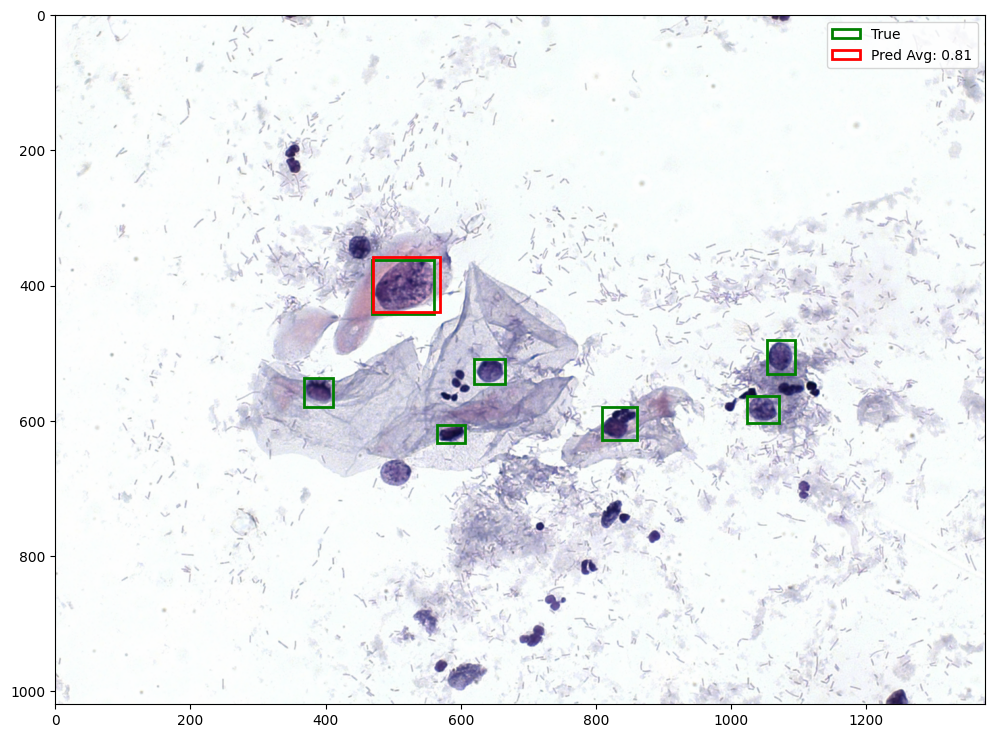

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def plot_boxes(image_path, true_boxes, pred_boxes_with_scores, pred_threshold=0.2):
    # Cargar la imagen
    image = Image.open(image_path).convert("RGB")
    
    # Crear una figura y un eje
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)
    
    # Dibujar las bounding boxes reales en verde
    for box in true_boxes:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='green', facecolor='none', label="True")
        ax.add_patch(rect)
    
    # Filtrar las bounding boxes predichas según el umbral
    filtered_boxes_with_scores = [(box, score) for box, score in pred_boxes_with_scores if score >= pred_threshold]
    
    if filtered_boxes_with_scores:
        # Calcular el promedio de los scores
        avg_score = np.mean([score for _, score in filtered_boxes_with_scores])
        
        # Dibujar las bounding boxes predichas con el score promedio como etiqueta
        for box, _ in filtered_boxes_with_scores:
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none', label=f"Pred Avg: {avg_score:.2f}")
            ax.add_patch(rect)
    
    # Mostrar la leyenda y la imagen
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    plt.show()

# Seleccionar una imagen del conjunto de validación y extraer las bounding boxes reales
sample_idx = 9  # Cambia este valor para seleccionar otra imagen
sample = val_data[sample_idx]
image_path = os.path.join(image_dir, sample['file_upload'].split('-', 1)[-1])
true_boxes, _ = get_boxes_and_labels(sample)

# Realizar detección con el modelo entrenado
model.eval()
image_tensor = transforms.ToTensor()(Image.open(image_path)).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(image_tensor)[0]

# Extraer las bounding boxes y los scores de las predicciones
pred_boxes = output['boxes'].detach().cpu().numpy()
pred_scores = output['scores'].detach().cpu().numpy()
pred_boxes_with_scores = [(box, score) for box, score in zip(pred_boxes, pred_scores)]

# Visualizar la imagen con las bounding boxes reales y predichas
plot_boxes(image_path, true_boxes, pred_boxes_with_scores)

# Unet con bb Fijas

## Binary Crossentropy como función de pérdida

In [2]:
import os
import json
import numpy as np
import tensorflow as tf
import wandb
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from wandb.integration.keras import WandbCallback
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import label, find_objects

# Configuración de Weights & Biases
wandb.init(project="detecion-celulas", entity='tp3-td6', name="UNet")

# Ruta a tus datos
image_dir = 'base/'
annotations_path = 'classificationDownload/classifications.json'

# Cargar anotaciones
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Generador para cargar imágenes y máscaras en lotes
class DataGenerator(Sequence):
    def __init__(self, image_dir, annotations, batch_size=2, box_size=45, image_size=(1020, 1376), shuffle=True):
        self.image_dir = image_dir
        self.annotations = annotations
        self.batch_size = batch_size
        self.box_size = box_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.annotations))
        self.on_epoch_end()

    def __len__(self):
        return len(self.annotations) // self.batch_size

    def __getitem__(self, index):
        # Generar índices para el batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Encontrar anotaciones para los índices seleccionados
        batch_annotations = [self.annotations[i] for i in indexes]
        
        # Cargar datos
        images, masks = self.__data_generation(batch_annotations)
        return images, masks

    def on_epoch_end(self):
        # Barajar índices si es necesario
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_annotations):
        images = []
        masks = []
        
        for annotation in batch_annotations:
            image_path = os.path.join(self.image_dir, annotation["image_name"])
            image = load_img(image_path)  # No redimensionar
            image = img_to_array(image) / 255.0
            images.append(image)
            
            # Crear máscara para la imagen
            mask = np.zeros((*self.image_size, 1))
            for cell in annotation["classifications"]:
                x_center = cell["nucleus_x"]
                y_center = cell["nucleus_y"]
                x1, y1 = max(x_center - self.box_size, 0), max(y_center - self.box_size, 0)
                x2, y2 = min(x_center + self.box_size, self.image_size[1]), min(y_center + self.box_size, self.image_size[0])
                mask[y1:y2, x1:x2, 0] = 1
            masks.append(mask)
        
        return np.array(images), np.array(masks)

# Parámetros del generador
batch_size = 2
train_size = int(0.7 * len(annotations))
val_size = int(0.15 * len(annotations))

# Dividir las anotaciones   
annotations_train = annotations[:train_size]
annotations_val = annotations[train_size:train_size + val_size]
annotations_test = annotations[train_size + val_size:]

# Crear generadores para cada conjunto
train_generator = DataGenerator(image_dir, annotations_train, batch_size=batch_size)
val_generator = DataGenerator(image_dir, annotations_val, batch_size=batch_size)
test_generator = DataGenerator(image_dir, annotations_test, batch_size=batch_size)

# Definir el modelo U-Net con dimensiones originales
def unet_model(input_size=(1020, 1376, 3)):
    inputs = Input(input_size)
    # Downsampling
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    
    # Upsampling
    u1 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
    u2 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(8, (3, 3), activation='relu', padding='same')(u2)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = unet_model()

# Configurar callbacks para W&B y progreso en consola
callbacks = [
    WandbCallback(log_weights=False, log_gradients=False, save_model=False),  # Simplificar log a W&B
    tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
]

# Entrenar el modelo con el generador
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1  # Para ver solo las épocas sin detalles de cada paso
)

# Evaluar en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
wandb.log({"test_loss": test_loss, "test_accuracy": test_accuracy})


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/20
140/140 [==============================] - 143s 1s/step - loss: 0.3556 - accuracy: 0.8701 - val_loss: 0.3521 - val_accuracy: 0.8365
Epoch 2/20


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 139s 994ms/step - loss: 0.2603 - accuracy: 0.8854 - val_loss: 0.3455 - val_accuracy: 0.8333
Epoch 3/20
140/140 [==============================] - 143s 1s/step - loss: 0.2523 - accuracy: 0.8910 - val_loss: 0.3437 - val_accuracy: 0.8402
Epoch 4/20
140/140 [==============================] - 139s 990ms/step - loss: 0.2431 - accuracy: 0.8923 - val_loss: 0.3342 - val_accuracy: 0.8482
Epoch 5/20
140/140 [==============================] - 136s 970ms/step - loss: 0.2441 - accuracy: 0.8932 - val_loss: 0.3468 - val_accuracy: 0.8388
Epoch 6/20
140/140 [==============================] - 136s 973ms/step - loss: 0.2452 - accuracy: 0.8924 - val_loss: 0.3444 - val_accuracy: 0.8366
Epoch 7/20
140/140 [==============================] - 137s 977ms/step - loss: 0.2386 - accuracy: 0.8934 - val_loss: 0.3499 - val_accuracy: 0.8304
Epoch 8/20
140/140 [==============================] - 136s 971ms/step - loss: 0.2420 - accuracy: 0.8934 - val_loss: 0.3378 - val_accuracy:

1/1 [==============================] - 0s 109ms/step


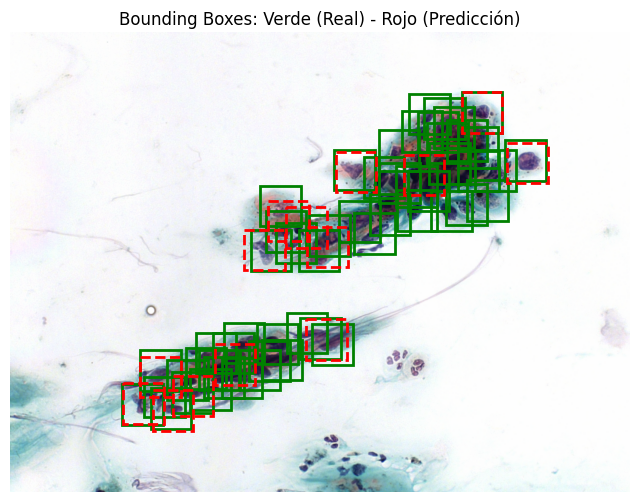

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.ndimage import label, find_objects

# Seleccionar el índice de una imagen específica para visualización
# En este caso, seleccionaremos una imagen de prueba directamente de las anotaciones originales
sample_index = 4  # Cambia este índice para seleccionar otra imagen
sample_annotation = annotations_test[sample_index]

# Cargar la imagen directamente del archivo
image_path = os.path.join(image_dir, sample_annotation["image_name"])
sample_image = load_img(image_path)  # No se redimensiona
sample_image = img_to_array(sample_image) / 255.0  # Normalizar

# Realiza la predicción para esta imagen
pred_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]
threshold = 0.5  # Umbral para la detección
pred_mask = (pred_mask > threshold).astype(np.uint8)

# Configuración del gráfico
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(sample_image)

# Dibujar bounding boxes reales (Verde)
box_size = 45  # Tamaño de la mitad de la bounding box 90x90
for cell in sample_annotation["classifications"]:
    x_center = cell["nucleus_x"]
    y_center = cell["nucleus_y"]
    x1, y1 = x_center - box_size, y_center - box_size
    rect = patches.Rectangle((x1, y1), 90, 90, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

# Dibujar bounding boxes predichas (Rojo punteado)
labeled_pred, _ = label(pred_mask)
min_area = 200  # Filtrar áreas pequeñas para precisión
for region in find_objects(labeled_pred):
    y1, y2 = region[0].start, region[0].stop
    x1, x2 = region[1].start, region[1].stop
    area = (x2 - x1) * (y2 - y1)
    
    if area >= min_area:
        x_center, y_center = (x1 + x2) // 2, (y1 + y2) // 2
        x1, y1 = x_center - box_size, y_center - box_size
        rect = patches.Rectangle((x1, y1), 90, 90, linewidth=2, edgecolor='r', linestyle='--', facecolor='none')
        ax.add_patch(rect)

# Mostrar el gráfico
plt.title("Bounding Boxes: Verde (Real) - Rojo (Predicción)")
plt.axis('off')
plt.show()

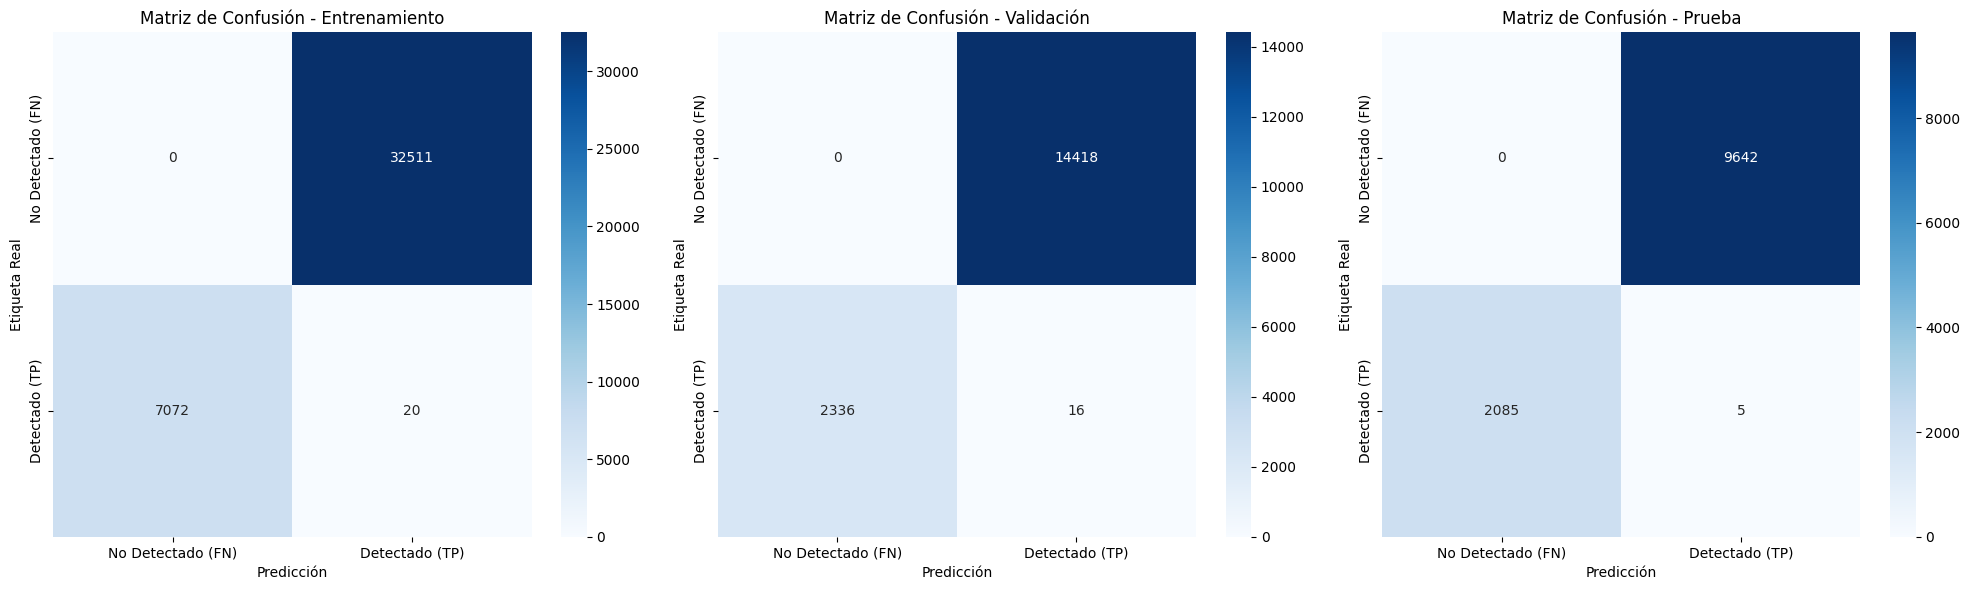

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
import contextlib

# Configuración del nivel de log para suprimir la salida de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Función para suprimir la salida de la consola
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull):
            yield

# Función para evaluar y calcular la matriz de confusión para un conjunto de datos
def evaluate_and_confusion_matrix(generator, annotations, set_name="Conjunto"):
    total_TP, total_FP, total_FN = 0, 0, 0

    for i in range(len(generator)):
        images, _ = generator[i]  # Obtiene el batch de imágenes
        for j in range(len(images)):
            with suppress_stdout():
                pred_mask = model.predict(np.expand_dims(images[j], axis=0))[0]
            pred_mask = (pred_mask > 0.5).astype(np.uint8)

            # Extraer bounding boxes de las predicciones
            labeled_pred, _ = label(pred_mask)
            predicted_boxes = []
            for region in find_objects(labeled_pred):
                y1, y2 = region[0].start, region[0].stop
                x1, x2 = region[1].start, region[1].stop
                predicted_boxes.append([x1, y1, x2, y2])

            # Obtener bounding boxes reales
            annotation = annotations[i * batch_size + j]
            real_boxes = []
            for cell in annotation["classifications"]:
                x_center = cell["nucleus_x"]
                y_center = cell["nucleus_y"]
                x1, y1 = x_center - 45, y_center - 45
                x2, y2 = x_center + 45, y_center + 45
                real_boxes.append([x1, y1, x2, y2])

            # Calcular TP, FP, FN para esta imagen
            TP, FP, FN = evaluate_image(real_boxes, predicted_boxes)
            total_TP += TP
            total_FP += FP
            total_FN += FN

    # Crear etiquetas para la matriz de confusión
    y_true = [1] * total_TP + [1] * total_FN + [0] * total_FP
    y_pred = [1] * total_TP + [0] * total_FN + [1] * total_FP

    # Generar y retornar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Definir las etiquetas de la clase
class_labels = ['No Detectado (FN)', 'Detectado (TP)']

# Calcular matrices de confusión para los tres conjuntos
cm_train = evaluate_and_confusion_matrix(train_generator, annotations_train, "Entrenamiento")
cm_val = evaluate_and_confusion_matrix(val_generator, annotations_val, "Validación")
cm_test = evaluate_and_confusion_matrix(test_generator, annotations_test, "Prueba")

# Visualizar las matrices de confusión lado a lado
plt.figure(figsize=(20, 6))

# Gráfico de la matriz de confusión para Entrenamiento
plt.subplot(1, 3, 1)
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Entrenamiento')

# Gráfico de la matriz de confusión para Validación
plt.subplot(1, 3, 2)
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Validación')

# Gráfico de la matriz de confusión para Prueba
plt.subplot(1, 3, 3)
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Prueba')

plt.tight_layout()
plt.show()

##  IoU (Intersection over Union) como función de pérdida

In [22]:
import os
import json
import numpy as np
import tensorflow as tf
import wandb
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from wandb.integration.keras import WandbCallback
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import label, find_objects

# Configuración de Weights & Biases
wandb.init(project="detecion-celulas", entity='tp3-td6', name="UNet_IoU_Loss")

# Ruta a tus datos
image_dir = 'base/'
annotations_path = 'classificationDownload/classifications.json'

# Cargar anotaciones
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Definir función de pérdida basada en IoU
def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return 1 - iou

# Generador para cargar imágenes y máscaras en lotes
class DataGenerator(Sequence):
    def __init__(self, image_dir, annotations, batch_size=2, box_size=45, image_size=(1020, 1376), shuffle=True):
        self.image_dir = image_dir
        self.annotations = annotations
        self.batch_size = batch_size
        self.box_size = box_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.annotations))
        self.on_epoch_end()

    def __len__(self):
        return len(self.annotations) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_annotations = [self.annotations[i] for i in indexes]
        images, masks = self.__data_generation(batch_annotations)
        return images, masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_annotations):
        images = []
        masks = []
        
        for annotation in batch_annotations:
            image_path = os.path.join(self.image_dir, annotation["image_name"])
            image = load_img(image_path)
            image = img_to_array(image) / 255.0
            images.append(image)
            
            mask = np.zeros((*self.image_size, 1))
            for cell in annotation["classifications"]:
                x_center = cell["nucleus_x"]
                y_center = cell["nucleus_y"]
                x1, y1 = max(x_center - self.box_size, 0), max(y_center - self.box_size, 0)
                x2, y2 = min(x_center + self.box_size, self.image_size[1]), min(y_center + self.box_size, self.image_size[0])
                mask[y1:y2, x1:x2, 0] = 1
            masks.append(mask)
        
        return np.array(images), np.array(masks)

# Parámetros del generador
batch_size = 2
train_size = int(0.7 * len(annotations))
val_size = int(0.15 * len(annotations))

annotations_train = annotations[:train_size]
annotations_val = annotations[train_size:train_size + val_size]
annotations_test = annotations[train_size + val_size:]

train_generator = DataGenerator(image_dir, annotations_train, batch_size=batch_size)
val_generator = DataGenerator(image_dir, annotations_val, batch_size=batch_size)
test_generator = DataGenerator(image_dir, annotations_test, batch_size=batch_size)

# Definir el modelo U-Net con IoU Loss
def unet_model(input_size=(1020, 1376, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    
    u1 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
    u2 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(8, (3, 3), activation='relu', padding='same')(u2)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=iou_loss, metrics=['accuracy'])
    
    return model

model = unet_model()

# Configurar callbacks para W&B
callbacks = [
    WandbCallback(log_weights=False, log_gradients=False, save_model=False),
    tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
]

# Entrenar el modelo con la nueva función de pérdida
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
wandb.log({"test_loss": test_loss, "test_accuracy": test_accuracy})

Epoch 1/20
140/140 [==============================] - 139s 986ms/step - loss: 0.7185 - accuracy: 0.7966 - val_loss: 0.6717 - val_accuracy: 0.7509
Epoch 2/20


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 137s 981ms/step - loss: 0.6713 - accuracy: 0.8366 - val_loss: 0.6712 - val_accuracy: 0.7775
Epoch 3/20
140/140 [==============================] - 134s 958ms/step - loss: 0.6549 - accuracy: 0.8406 - val_loss: 0.6747 - val_accuracy: 0.7150
Epoch 4/20
140/140 [==============================] - 135s 966ms/step - loss: 0.6633 - accuracy: 0.8435 - val_loss: 0.6635 - val_accuracy: 0.7483
Epoch 5/20
140/140 [==============================] - 133s 950ms/step - loss: 0.6471 - accuracy: 0.8485 - val_loss: 0.6630 - val_accuracy: 0.7522
Epoch 6/20
140/140 [==============================] - 134s 955ms/step - loss: 0.6454 - accuracy: 0.8476 - val_loss: 0.6636 - val_accuracy: 0.7858
Epoch 7/20
140/140 [==============================] - 138s 986ms/step - loss: 0.6451 - accuracy: 0.8478 - val_loss: 0.6690 - val_accuracy: 0.7177
Epoch 8/20
140/140 [==============================] - 142s 1s/step - loss: 0.6425 - accuracy: 0.8505 - val_loss: 0.6477 - val_accuracy:

1/1 [==============================] - 0s 146ms/step


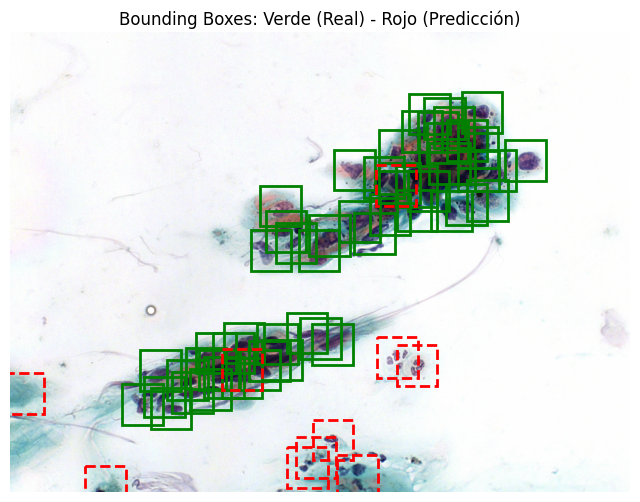

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.ndimage import label, find_objects

# Seleccionar el índice de una imagen específica para visualización
# En este caso, seleccionaremos una imagen de prueba directamente de las anotaciones originales
sample_index = 4  # Cambia este índice para seleccionar otra imagen
sample_annotation = annotations_test[sample_index]

# Cargar la imagen directamente del archivo
image_path = os.path.join(image_dir, sample_annotation["image_name"])
sample_image = load_img(image_path)  # No se redimensiona
sample_image = img_to_array(sample_image) / 255.0  # Normalizar

# Realiza la predicción para esta imagen
pred_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]
threshold = 0.5  # Umbral para la detección
pred_mask = (pred_mask > threshold).astype(np.uint8)

# Configuración del gráfico
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(sample_image)

# Dibujar bounding boxes reales (Verde)
box_size = 45  # Tamaño de la mitad de la bounding box 90x90
for cell in sample_annotation["classifications"]:
    x_center = cell["nucleus_x"]
    y_center = cell["nucleus_y"]
    x1, y1 = x_center - box_size, y_center - box_size
    rect = patches.Rectangle((x1, y1), 90, 90, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

# Dibujar bounding boxes predichas (Rojo punteado)
labeled_pred, _ = label(pred_mask)
min_area = 200  # Filtrar áreas pequeñas para precisión
for region in find_objects(labeled_pred):
    y1, y2 = region[0].start, region[0].stop
    x1, x2 = region[1].start, region[1].stop
    area = (x2 - x1) * (y2 - y1)
    
    if area >= min_area:
        x_center, y_center = (x1 + x2) // 2, (y1 + y2) // 2
        x1, y1 = x_center - box_size, y_center - box_size
        rect = patches.Rectangle((x1, y1), 90, 90, linewidth=2, edgecolor='r', linestyle='--', facecolor='none')
        ax.add_patch(rect)

# Mostrar el gráfico
plt.title("Bounding Boxes: Verde (Real) - Rojo (Predicción)")
plt.axis('off')
plt.show()

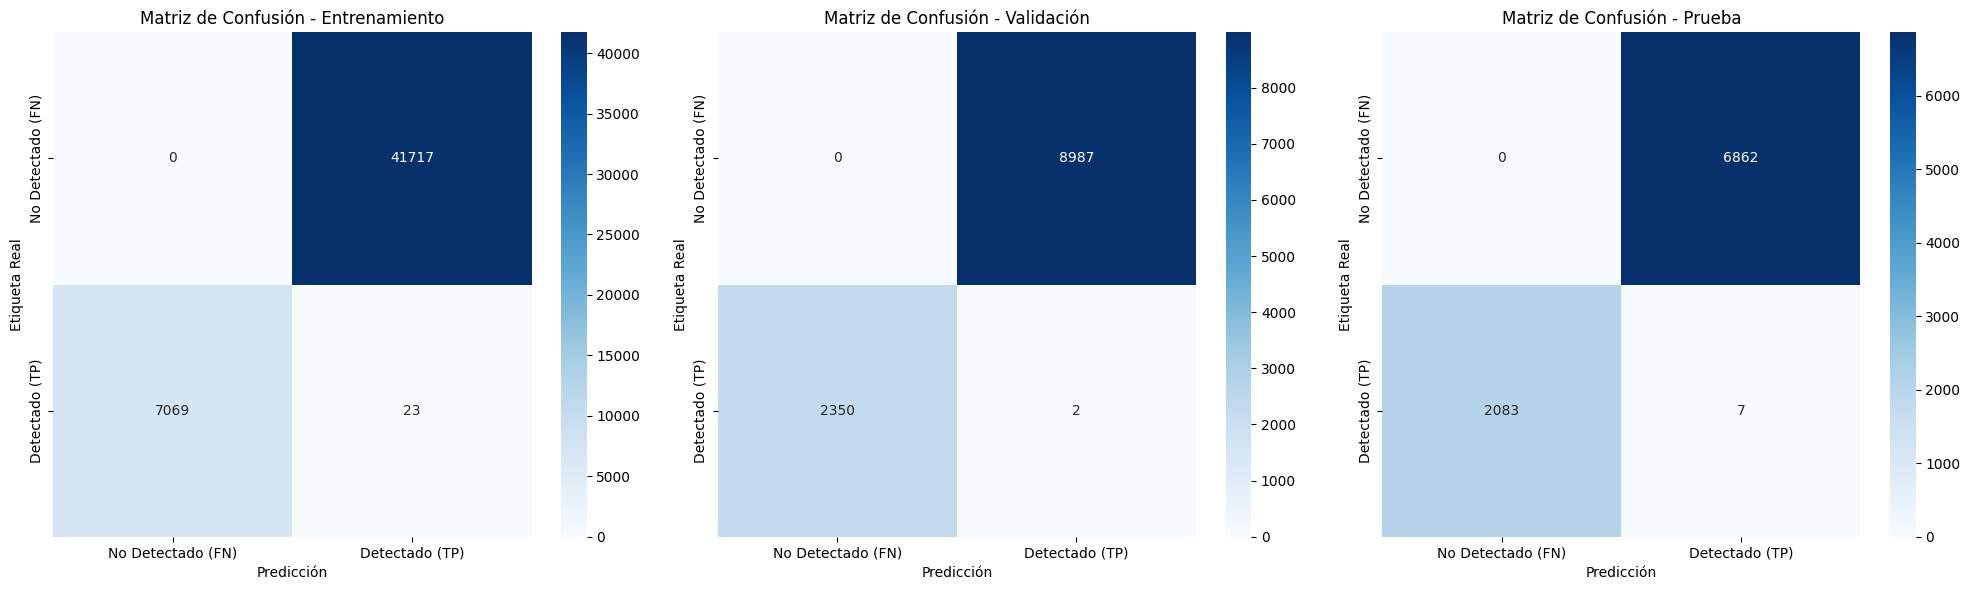

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
import contextlib

# Configuración del nivel de log para suprimir la salida de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Función para suprimir la salida de la consola
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull):
            yield

# Función para evaluar y calcular la matriz de confusión para un conjunto de datos
def evaluate_and_confusion_matrix(generator, annotations, set_name="Conjunto"):
    total_TP, total_FP, total_FN = 0, 0, 0

    for i in range(len(generator)):
        images, _ = generator[i]  # Obtiene el batch de imágenes
        for j in range(len(images)):
            with suppress_stdout():
                pred_mask = model.predict(np.expand_dims(images[j], axis=0))[0]
            pred_mask = (pred_mask > 0.5).astype(np.uint8)

            # Extraer bounding boxes de las predicciones
            labeled_pred, _ = label(pred_mask)
            predicted_boxes = []
            for region in find_objects(labeled_pred):
                y1, y2 = region[0].start, region[0].stop
                x1, x2 = region[1].start, region[1].stop
                predicted_boxes.append([x1, y1, x2, y2])

            # Obtener bounding boxes reales
            annotation = annotations[i * batch_size + j]
            real_boxes = []
            for cell in annotation["classifications"]:
                x_center = cell["nucleus_x"]
                y_center = cell["nucleus_y"]
                x1, y1 = x_center - 45, y_center - 45
                x2, y2 = x_center + 45, y_center + 45
                real_boxes.append([x1, y1, x2, y2])

            # Calcular TP, FP, FN para esta imagen
            TP, FP, FN = evaluate_image(real_boxes, predicted_boxes)
            total_TP += TP
            total_FP += FP
            total_FN += FN

    # Crear etiquetas para la matriz de confusión
    y_true = [1] * total_TP + [1] * total_FN + [0] * total_FP
    y_pred = [1] * total_TP + [0] * total_FN + [1] * total_FP

    # Generar y retornar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Definir las etiquetas de la clase
class_labels = ['No Detectado (FN)', 'Detectado (TP)']

# Calcular matrices de confusión para los tres conjuntos
cm_train = evaluate_and_confusion_matrix(train_generator, annotations_train, "Entrenamiento")
cm_val = evaluate_and_confusion_matrix(val_generator, annotations_val, "Validación")
cm_test = evaluate_and_confusion_matrix(test_generator, annotations_test, "Prueba")

# Visualizar las matrices de confusión lado a lado
plt.figure(figsize=(20, 6))

# Gráfico de la matriz de confusión para Entrenamiento
plt.subplot(1, 3, 1)
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Entrenamiento')

# Gráfico de la matriz de confusión para Validación
plt.subplot(1, 3, 2)
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Validación')

# Gráfico de la matriz de confusión para Prueba
plt.subplot(1, 3, 3)
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Prueba')

plt.tight_layout()
plt.show()

##  IoU como función de pérdida con algunas modificaciones

In [25]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from wandb.integration.keras import WandbCallback
import wandb

# Configuración de Weights & Biases
wandb.init(project="detecion-celulas", entity='tp3-td6', name="UNet-IoU")

# Ruta a tus datos
image_dir = 'base/'
annotations_path = 'classificationDownload/classifications.json'

# Cargar anotaciones
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Generador para cargar imágenes y máscaras en lotes
class DataGenerator(Sequence):
    def __init__(self, image_dir, annotations, batch_size=2, box_size=45, image_size=(1020, 1376), shuffle=True):
        self.image_dir = image_dir
        self.annotations = annotations
        self.batch_size = batch_size
        self.box_size = box_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.annotations))
        self.on_epoch_end()

    def __len__(self):
        return len(self.annotations) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_annotations = [self.annotations[i] for i in indexes]
        images, masks = self.__data_generation(batch_annotations)
        return images, masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_annotations):
        images, masks = [], []
        for annotation in batch_annotations:
            image_path = os.path.join(self.image_dir, annotation["image_name"])
            image = load_img(image_path)  # No redimensionar
            image = img_to_array(image) / 255.0
            images.append(image)
            
            mask = np.zeros((*self.image_size, 1))
            for cell in annotation["classifications"]:
                x_center = cell["nucleus_x"]
                y_center = cell["nucleus_y"]
                x1, y1 = max(x_center - self.box_size, 0), max(y_center - self.box_size, 0)
                x2, y2 = min(x_center + self.box_size, self.image_size[1]), min(y_center + self.box_size, self.image_size[0])
                mask[y1:y2, x1:x2, 0] = 1
            masks.append(mask)
        return np.array(images), np.array(masks)

# Definir la métrica de IoU
def iou_metric(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

# Definir la métrica personalizada de precisión con un ajuste de threshold
def precision_recall_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return precision, recall

# Crear el modelo U-Net
def unet_model(input_size=(1020, 1376, 3), threshold=0.5):
    inputs = Input(input_size)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    u1 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
    u2 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(8, (3, 3), activation='relu', padding='same')(u2)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=[iou_metric, lambda y_true, y_pred: precision_recall_metric(y_true, y_pred, threshold)])
    return model

# Crear generadores para entrenamiento, validación y prueba
batch_size = 2
train_size = int(0.7 * len(annotations))
val_size = int(0.15 * len(annotations))
annotations_train = annotations[:train_size]
annotations_val = annotations[train_size:train_size + val_size]
annotations_test = annotations[train_size + val_size:]

train_generator = DataGenerator(image_dir, annotations_train, batch_size=batch_size)
val_generator = DataGenerator(image_dir, annotations_val, batch_size=batch_size)
test_generator = DataGenerator(image_dir, annotations_test, batch_size=batch_size)

# Ajustar el modelo para entrenar con la métrica IoU
model = unet_model()

# Configurar callbacks para W&B
callbacks = [
    WandbCallback(log_weights=False, log_gradients=False, save_model=False),  
    tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5", save_best_only=True, monitor='val_iou_metric', mode='max', verbose=0)
]

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Evaluar en el conjunto de prueba
test_loss, test_iou, test_precision, test_recall = model.evaluate(test_generator, verbose=0)
wandb.log({"test_loss": test_loss, "test_iou": test_iou, "test_precision": test_precision, "test_recall": test_recall})
wandb.finish()

Epoch 1/20
140/140 [==============================] - 142s 1s/step - loss: 0.3322 - iou_metric: 0.1004 - <lambda>: 0.0041 - val_loss: 0.3575 - val_iou_metric: 0.1632 - val_<lambda>: 0.0000e+00
Epoch 2/20


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 137s 976ms/step - loss: 0.2674 - iou_metric: 0.1637 - <lambda>: 0.2943 - val_loss: 0.3479 - val_iou_metric: 0.2104 - val_<lambda>: 0.4713
Epoch 3/20
140/140 [==============================] - 141s 1s/step - loss: 0.2553 - iou_metric: 0.1916 - <lambda>: 0.4593 - val_loss: 0.3431 - val_iou_metric: 0.2196 - val_<lambda>: 0.4745
Epoch 4/20
140/140 [==============================] - 137s 978ms/step - loss: 0.2464 - iou_metric: 0.2022 - <lambda>: 0.4552 - val_loss: 0.3502 - val_iou_metric: 0.2413 - val_<lambda>: 0.4829
Epoch 5/20
140/140 [==============================] - 137s 980ms/step - loss: 0.2447 - iou_metric: 0.2095 - <lambda>: 0.4652 - val_loss: 0.3570 - val_iou_metric: 0.2340 - val_<lambda>: 0.4882
Epoch 6/20
140/140 [==============================] - 136s 970ms/step - loss: 0.2404 - iou_metric: 0.2124 - <lambda>: 0.4605 - val_loss: 0.3494 - val_iou_metric: 0.2356 - val_<lambda>: 0.4905
Epoch 7/20
140/140 [==============================] - 

ValueError: not enough values to unpack (expected 4, got 3)

1/1 [==============================] - 0s 141ms/step


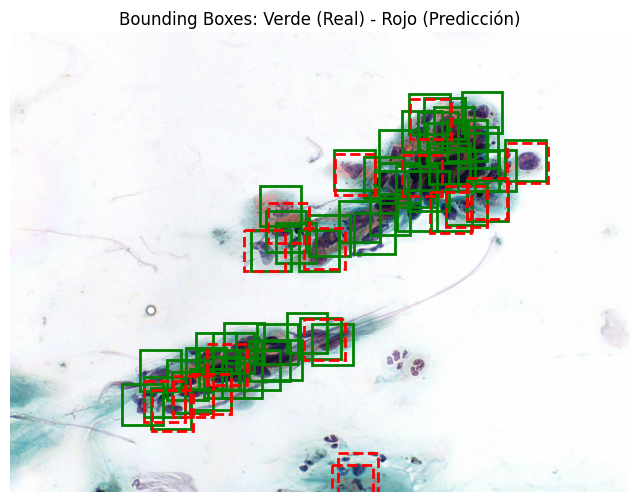

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.ndimage import label, find_objects

# Seleccionar el índice de una imagen específica para visualización
# En este caso, seleccionaremos una imagen de prueba directamente de las anotaciones originales
sample_index = 4  # Cambia este índice para seleccionar otra imagen
sample_annotation = annotations_test[sample_index]

# Cargar la imagen directamente del archivo
image_path = os.path.join(image_dir, sample_annotation["image_name"])
sample_image = load_img(image_path)  # No se redimensiona
sample_image = img_to_array(sample_image) / 255.0  # Normalizar

# Realiza la predicción para esta imagen
pred_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]
threshold = 0.5  # Umbral para la detección
pred_mask = (pred_mask > threshold).astype(np.uint8)

# Configuración del gráfico
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(sample_image)

# Dibujar bounding boxes reales (Verde)
box_size = 45  # Tamaño de la mitad de la bounding box 90x90
for cell in sample_annotation["classifications"]:
    x_center = cell["nucleus_x"]
    y_center = cell["nucleus_y"]
    x1, y1 = x_center - box_size, y_center - box_size
    rect = patches.Rectangle((x1, y1), 90, 90, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

# Dibujar bounding boxes predichas (Rojo punteado)
labeled_pred, _ = label(pred_mask)
min_area = 200  # Filtrar áreas pequeñas para precisión
for region in find_objects(labeled_pred):
    y1, y2 = region[0].start, region[0].stop
    x1, x2 = region[1].start, region[1].stop
    area = (x2 - x1) * (y2 - y1)
    
    if area >= min_area:
        x_center, y_center = (x1 + x2) // 2, (y1 + y2) // 2
        x1, y1 = x_center - box_size, y_center - box_size
        rect = patches.Rectangle((x1, y1), 90, 90, linewidth=2, edgecolor='r', linestyle='--', facecolor='none')
        ax.add_patch(rect)

# Mostrar el gráfico
plt.title("Bounding Boxes: Verde (Real) - Rojo (Predicción)")
plt.axis('off')
plt.show()

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
import contextlib

# Configuración del nivel de log para suprimir la salida de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Función para suprimir la salida de la consola
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull):
            yield

# Función para evaluar y calcular la matriz de confusión para un conjunto de datos
def evaluate_and_confusion_matrix(generator, annotations, set_name="Conjunto"):
    total_TP, total_FP, total_FN = 0, 0, 0

    for i in range(len(generator)):
        images, _ = generator[i]  # Obtiene el batch de imágenes
        for j in range(len(images)):
            with suppress_stdout():
                pred_mask = model.predict(np.expand_dims(images[j], axis=0))[0]
            pred_mask = (pred_mask > 0.5).astype(np.uint8)

            # Extraer bounding boxes de las predicciones
            labeled_pred, _ = label(pred_mask)
            predicted_boxes = []
            for region in find_objects(labeled_pred):
                y1, y2 = region[0].start, region[0].stop
                x1, x2 = region[1].start, region[1].stop
                predicted_boxes.append([x1, y1, x2, y2])

            # Obtener bounding boxes reales
            annotation = annotations[i * batch_size + j]
            real_boxes = []
            for cell in annotation["classifications"]:
                x_center = cell["nucleus_x"]
                y_center = cell["nucleus_y"]
                x1, y1 = x_center - 45, y_center - 45
                x2, y2 = x_center + 45, y_center + 45
                real_boxes.append([x1, y1, x2, y2])

            # Calcular TP, FP, FN para esta imagen
            TP, FP, FN = evaluate_image(real_boxes, predicted_boxes)
            total_TP += TP
            total_FP += FP
            total_FN += FN

    # Crear etiquetas para la matriz de confusión
    y_true = [1] * total_TP + [1] * total_FN + [0] * total_FP
    y_pred = [1] * total_TP + [0] * total_FN + [1] * total_FP

    # Generar y retornar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    return cm

# Definir las etiquetas de la clase
class_labels = ['No Detectado (FN)', 'Detectado (TP)']

# Calcular matrices de confusión para los tres conjuntos
cm_train = evaluate_and_confusion_matrix(train_generator, annotations_train, "Entrenamiento")
cm_val = evaluate_and_confusion_matrix(val_generator, annotations_val, "Validación")
cm_test = evaluate_and_confusion_matrix(test_generator, annotations_test, "Prueba")

# Visualizar las matrices de confusión lado a lado
plt.figure(figsize=(20, 6))

# Gráfico de la matriz de confusión para Entrenamiento
plt.subplot(1, 3, 1)
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Entrenamiento')

# Gráfico de la matriz de confusión para Validación
plt.subplot(1, 3, 2)
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Validación')

# Gráfico de la matriz de confusión para Prueba
plt.subplot(1, 3, 3)
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Prueba')

plt.tight_layout()
plt.show()

NameError: name 'train_generator' is not defined

# FastRCNN con bb fijas

In [ ]:
import tensorflow as tf
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from wandb.integration.keras import WandbCallback
import wandb

# Configuración de Weights & Biases
wandb.init(project="detecion-celulas", entity='tp3-td6', name="UNet_TFRecords")

# Definir el archivo TFRecord
tfrecord_filename = 'nuclei_dataset.tfrecord'
image_dir = 'base/'
annotations_path = 'classificationDownload/classifications.json'

# Función para crear TFRecords
def create_tfrecord(image_dir, annotations, tfrecord_filename):
    with tf.io.TFRecordWriter(tfrecord_filename) as writer:
        for annotation in annotations:
            image_path = os.path.join(image_dir, annotation["image_name"])
            image = img_to_array(load_img(image_path)) / 255.0
            image_bytes = tf.io.encode_jpeg(tf.cast(image * 255, tf.uint8)).numpy()

            for cell in annotation["classifications"]:
                x_center = cell["nucleus_x"]
                y_center = cell["nucleus_y"]

                feature = {
                    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes])),
                    'x_center': tf.train.Feature(int64_list=tf.train.Int64List(value=[x_center])),
                    'y_center': tf.train.Feature(int64_list=tf.train.Int64List(value=[y_center])),
                }
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())

# Convertir a TFRecords
with open(annotations_path, 'r') as f:
    annotations = json.load(f)
create_tfrecord(image_dir, annotations, tfrecord_filename)

# Función para parsear TFRecords
def parse_example(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'x_center': tf.io.FixedLenFeature([], tf.int64),
        'y_center': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(parsed_example['image'])
    image = tf.image.resize(image, [1020, 1376])  # Asegurar tamaño correcto
    image = tf.cast(image, tf.float32) / 255.0
    x_center = parsed_example['x_center']
    y_center = parsed_example['y_center']
    return image, {'x_center': x_center, 'y_center': y_center}

# Crear dataset y ajustar el batch
batch_size = 2  # Ajustar según los recursos
raw_dataset = tf.data.TFRecordDataset(tfrecord_filename)
parsed_dataset = raw_dataset.map(parse_example).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Definir el modelo U-Net
def unet_model(input_size=(1020, 1376, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    u1 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
    u2 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(8, (3, 3), activation='relu', padding='same')(u2)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Crear el modelo
model = unet_model()

# Configurar callbacks
callbacks = [
    WandbCallback(log_weights=False, save_model=False),
    tf.keras.callbacks.ModelCheckpoint(filepath="best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
]

# Entrenar el modelo
history = model.fit(
    parsed_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Terminar sesión de W&B
wandb.finish()